### Here we check individual dataset group models to see whether orbito-frontal weights are caused by a specific dataset or not


In [1]:
import numpy as np
import pandas as pd
import nibabel as nb
import Functional_Fusion.dataset as fdata # from functional fusion module
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import cortico_cereb_connectivity.data as cdata
import cortico_cereb_connectivity.cio as cio
import cortico_cereb_connectivity.summarize as cs
import cortico_cereb_connectivity.scripts.script_summarize_weights as cssw
import matplotlib.pyplot as plt
import seaborn as sns
import Functional_Fusion.atlas_map as am
import nitools as nt
import warnings
import SUITPy as suit
from scipy import stats
from statsmodels.stats.multitest import multipletests

/home/UWO/ashahb7/Documents/cortico/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/UWO/ashahb7/Documents/cortico/lib/python3.8/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [2]:
parcellation = 'Icosahedron1002'
method = 'NNLS'
stats_to_calc = 'prob'

yeo_img = nb.load(gl.conn_dir + f'/maps/yeo17_{parcellation}.plabel.nii')
yeo_data = yeo_img.get_fdata().squeeze()
label_dict = yeo_img.header.get_axis(0).label[0]
atlas,ainf = am.get_atlas('MNISymC3')

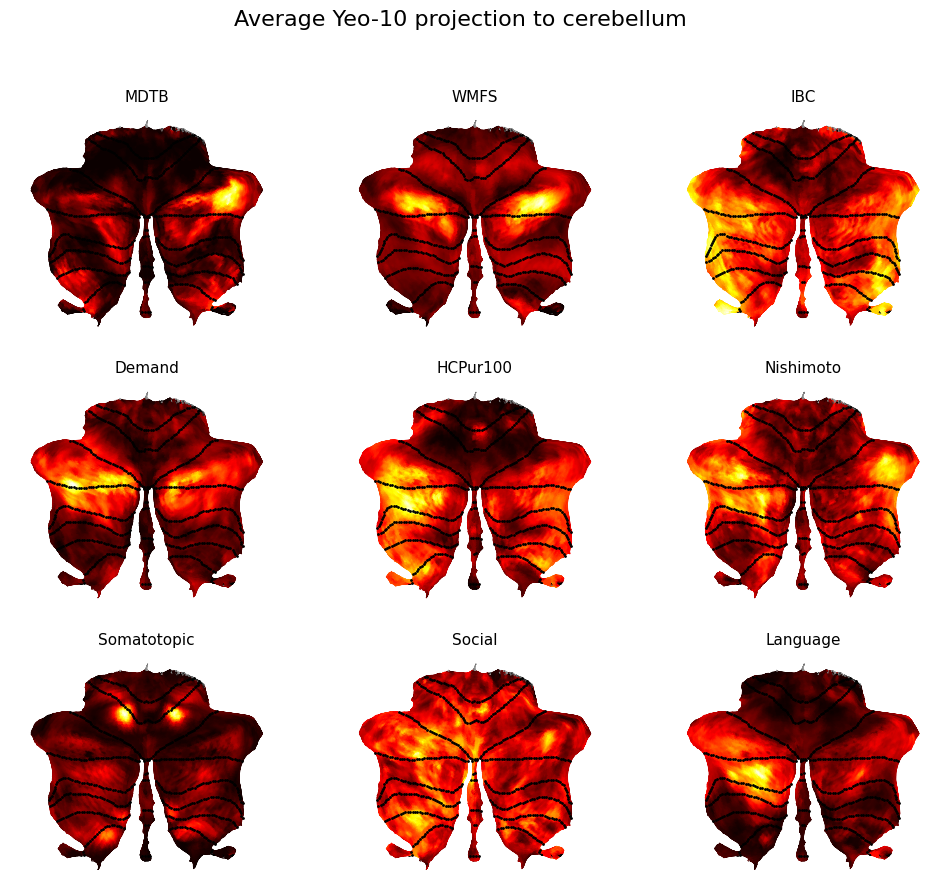

In [3]:
fig, axes = plt.subplots(np.ceil(len(gl.datasets)/3).astype(int), 3, figsize=(12, 10))
for i, (traindata, ses) in enumerate(zip(gl.datasets, gl.sessions)):
    mroot = f"{traindata}_{ses}_{parcellation}_{method}"
    model, _ = cio.load_model(gl.conn_dir + f"/MNISymC3/train/{mroot}/{mroot}_A0_group")  

    project = model.coef_[:, yeo_data==10].mean(axis=1)
    nifti_image = atlas.data_to_nifti(project)
    data = suit.vol_to_surf(nifti_image,space='MNISymC')
    plt.subplot(np.ceil(len(gl.datasets)/3).astype(int), 3, i+1)
    suit.flatmap.plot(data,cmap='hot', new_figure=False)
    axes.flat[i].set_title(traindata, fontsize=11)
plt.suptitle(f'Average Yeo-10 projection to cerebellum', fontsize=16);

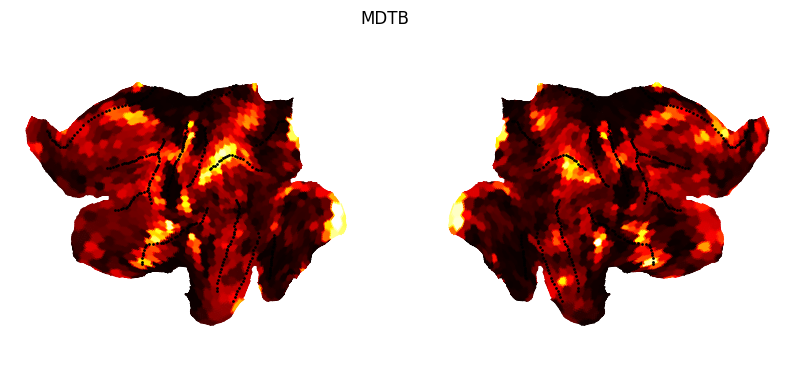

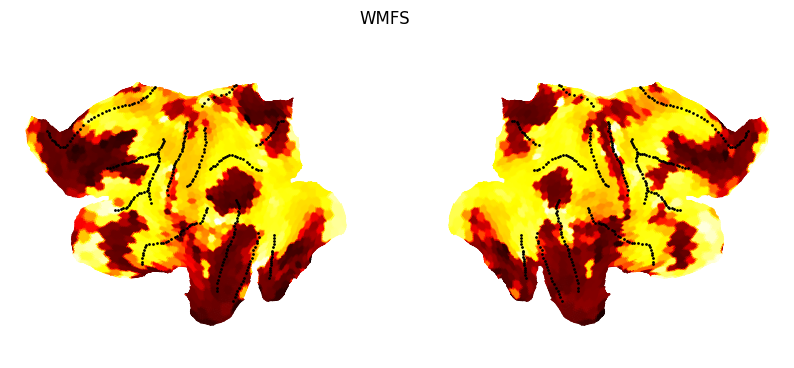

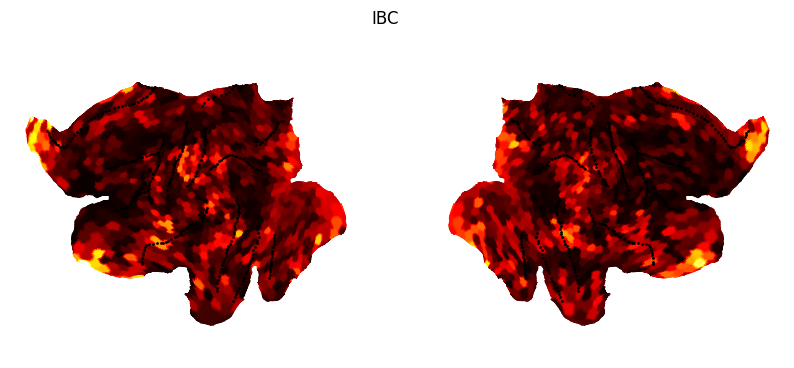

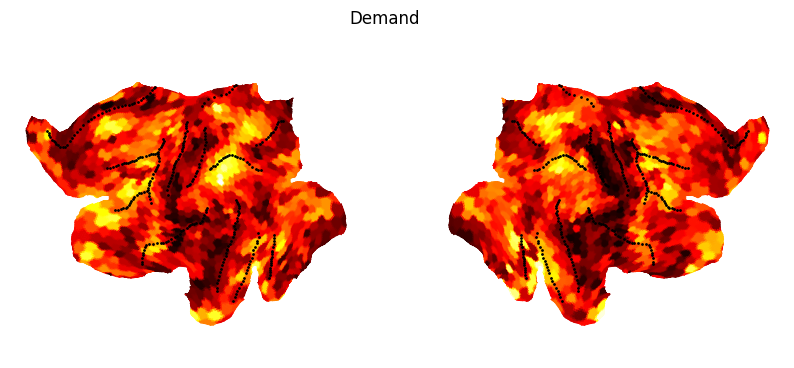

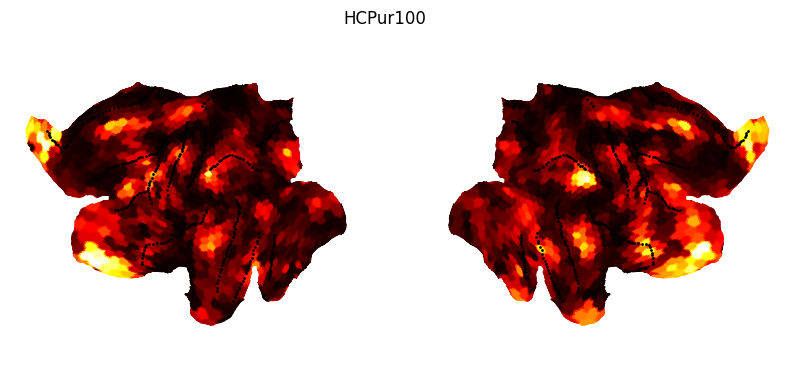

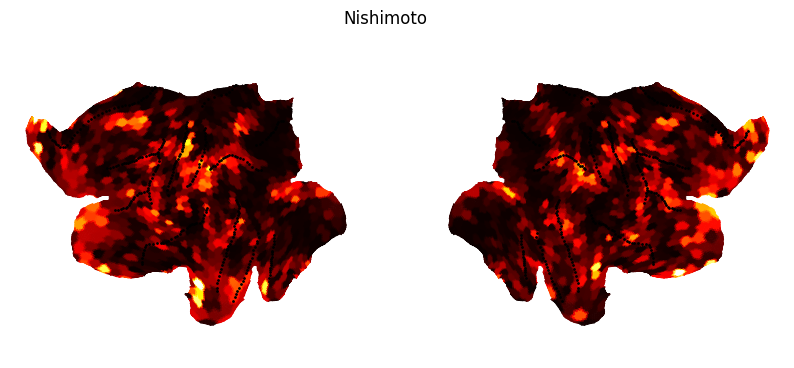

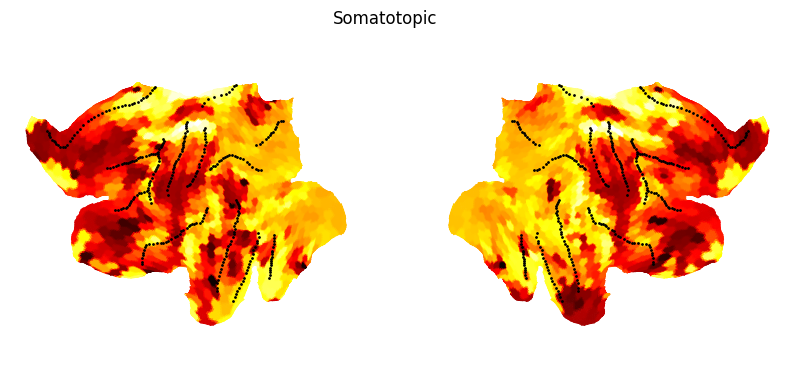

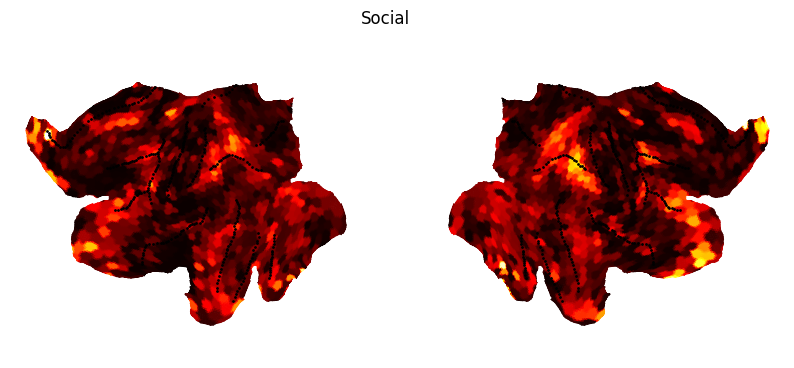

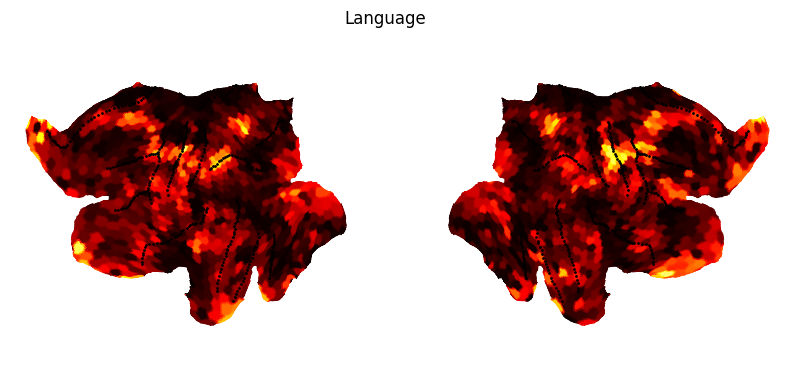

In [3]:
for traindata, ses in zip(gl.datasets, gl.sessions):
    cifti_img = cs.stats_weight_map_cortex(traindata = f"{traindata}_{ses}",
                            cortex_roi = parcellation,
                            method = method,
                            extension='A0_group',
                            stats = stats_to_calc)
    
    # smoothing
    fname = f'{traindata}_{parcellation}_{method}_{stats_to_calc}.pscalar.nii'
    oname = f'{traindata}_{parcellation}_{method}_{stats_to_calc}.dscalar.nii'
    nb.save(cifti_img, gl.conn_dir + f'/maps/{fname}')
    # cs.pscalar_to_smoothed_dscalar(fname,oname)

    # plot
    cifti_img = nb.load(gl.conn_dir + f'/maps/{fname}')
    data = nt.surf_from_cifti(cifti_img)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), )#subplot_kw={'projection': '3d'})
    cs.plot_cortical_flatmap(data=data, axes=axes, cmap='hot')
    # cs.plot_cortical_flatmap(data=data, axes=axes, cscale=[0, 1], cmap='hot')
    # cs.plot_cortical_inflated(data=data, axes=axes, cscale=[np.nanmin(data[0])*0.8, np.nanmax(data[0])*1.])
    plt.suptitle(traindata, fontsize=12)
    plt.show()

In [4]:
for traindata, ses in zip(gl.datasets, gl.sessions):
    model,info = cs.get_model(f"{traindata}_{ses}", parcellation ,method, 'A0_group')
    if stats_to_calc == 'mean':
        values = np.mean(model.coef_,axis=0,keepdims=True).T
    if stats_to_calc == 'prob':
        values = np.mean(model.coef_>0,axis=0,keepdims=True).T
    
    pvals = []
    for i in range(17):
        region_vals = values[yeo_data == i+1]
        other_vals = values[yeo_data != i+1]

        # Mann–Whitney U (region vs others)
        _, p = stats.mannwhitneyu(region_vals, other_vals, alternative="greater")
        pvals.append(p)

    pvals = np.array(pvals).ravel()
    # Multiple comparison correction
    reject, pvals_corr, _, _ = multipletests(pvals, method="fdr_bh")

    print("\n---------------------------------\n")
    print(f"Dataset: {traindata}:")
    for i, (pc, r) in enumerate(zip(pvals_corr, reject)):
        if r == True:
            print(label_dict[i+1][0], "p_adj =", pc)


---------------------------------

Dataset: MDTB:
06.DorsalAttentionB p_adj = 4.470550683402161e-07
08.VentralAttentionB p_adj = 0.00041605903871970283
11.ControlC p_adj = 0.002705503042368391
12.ControlA p_adj = 3.746772221734026e-10
13.ControlB p_adj = 2.545693411330773e-05
17.DefaultB p_adj = 0.00041605903871970283

---------------------------------

Dataset: WMFS:
01.VisualA p_adj = 3.3094390878022843e-17
05.DorsalAttentionA p_adj = 8.679377446605142e-20
06.DorsalAttentionB p_adj = 4.130890581970047e-07
07.VentralAttentionA p_adj = 0.007532286290358927
08.VentralAttentionB p_adj = 1.336374109248965e-16
11.ControlC p_adj = 0.0010915119539533196
12.ControlA p_adj = 1.3024996593285105e-21
14.TemporalParietal p_adj = 0.0010915119539533196

---------------------------------

Dataset: IBC:
01.VisualA p_adj = 0.0011536575692650919
02.VisualB p_adj = 9.479572958160245e-12
10.LimbicB p_adj = 9.599350181383542e-20

---------------------------------

Dataset: Demand:
01.VisualA p_adj = 2.592